# Transporter analysis of bacillus mother-spore

In [1]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP

# python imports
from copy import copy
import re
from os.path import join, dirname, abspath
import sys
sys.path.append('/home/UCSD/cobra_utils')
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra
from tqdm import tqdm
import numpy as np
import scipy

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import bacillusme
from bacillusme import (transcription, translation, flat_files, generics, formulas, compartments)
from bacillusme.util.helper_functions import *

import copy

%load_ext autoreload
%autoreload 2
print(cobra.__file__)
print(cobrame.__file__)
print(bacillusme.__file__)
ecoli_files = dirname(abspath(bacillusme.__file__))

/home/jt/Downloads/cobrapy-0.5.11/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/home/jt/Downloads/cobrapy-0.5.11/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


/home/jt/Downloads/cobrapy-0.5.11/cobra/__init__.py
/home/jt/UCSD/cobrame-master/cobrame/__init__.py
/home/jt/UCSD/bacillusme-master/bacillusme/__init__.py


In [2]:
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [3]:
with open("./sporeme_solution.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [4]:
# Previously identified essential metabolites
exchange_list = ['4fe4s_s','2fe2s_s','udcpp_s','pydx5p_s','3fe4s_s','cl_s','sheme_s','cu_s','mn2_s',
                 'bmocogdp_s','dpm_s','thmpp_s','zn2_s','cbl1_s','cobalt2_s']
additional = [m.id for m in sporeme.metabolites if isinstance(m,cobrame.Metabolite)]
transported_metabolites = exchange_list+additional

In [24]:
# Get transport reactions

def get_compartments(r):
    comps = []
    if isinstance(r,cobrame.MetabolicReaction):
        for m in r.metabolites:
            if isinstance(m,cobrame.Metabolite):
                comps.append(m.id[-1])
    return list(set(comps))

def get_all_transport(model):
    transport_reactions = []
    for r in tqdm(model.reactions):
        comps = get_compartments(r)
        if len(comps) > 1 and 's' in comps:
            transport_reactions.append(r.id)
    return list(set(transport_reactions))

def get_active_transport(transport_reactions):
    active_transporters = []
    for r in tqdm(transport_reactions):
        if 'SPONT' not in r and abs(sporeme.solution.x_dict[r])>0.:
            active_transporters.append(r)
    # Include arginine transport
    arginine_transport = [r.id for r in get_transport_reactions(sporeme,'arg__L_c',comps=['c','s'])+get_transport_reactions(sporeme,'arg__L_c',comps=['s','c'])]
    [active_transporters.append(r) for r in arginine_transport]
    active_transporters = list(set(active_transporters))
    return active_transporters

In [25]:
transport_reactions = get_all_transport(sporeme)
print('{} transport reactions identified'.format(len(transport_reactions)))

100%|██████████| 12359/12359 [00:00<00:00, 69496.82it/s]

405 transport reactions identified


In [28]:
active_transporters = get_active_transport(transport_reactions)

100%|██████████| 405/405 [00:00<00:00, 84181.23it/s]


In [30]:
print('{} active transport reactions identified'.format(len(active_transporters)))

53 active transport reactions identified


In [31]:
for r in transport_reactions:
    if r not in active_transporters and 'SPONT' not in r:
        rxn = sporeme.reactions.get_by_id(r)
        rxn.upper_bound = 0 
        rxn.lower_bound = 0

In [ ]:
solve_me_model(sporeme, max_mu = 0.5, min_mu = .05, using_soplex=False, precision = 1e-6,growth_key = 'sigma')

In [ ]:
from bacillusme.analysis import sensitivity as ss
flux_results_df = ss.transporter_knockout(sporeme,active_transporters, \
                                        NP=10,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma')
flux_results_df.to_csv('comm_transport_flux_results.csv')

In [ ]:
# All of them:
flux_results_df = pd.read_csv('comm_transport_flux_results.csv',index_col=0)
(n, bins, patches) = plt.hist(flux_results_df.loc['biomass_dilution_s'])
plt.xlabel('Growth rate')
plt.ylabel('Counts')

In [ ]:
transport_dict = {}
for candidate in flux_results_df.drop('base',axis=1).columns:
    r = sporeme.reactions.get_by_id(candidate)
    mets = []
    [mets.append(re.split('_.$',m.id)[0]) for m in r.metabolites if isinstance(m,cobrame.Metabolite) and 'h_' not in m.id]
    mets = list(set(mets))
    transport_dict[candidate] = mets[0]
    
plt.figure(figsize=(13,3))
flux_results_df.loc['biomass_dilution_s'].sort_values().plot.bar()
plt.xlabel('Single knockout')
plt.ylabel('Spore growth rate')

In [ ]:
# Important transporters without gene so far
df = flux_results_df.loc['biomass_dilution_s'].sort_values().head(20)
df[df.index.str.contains('dummy')]

In [ ]:
output = flux_results_df.loc[flux_results_df.columns.to_list()+['biomass_dilution_s']]
output = output[output.any(axis=1)] # Only reactions that carried flux in at least one knockout

In [ ]:
plt.figure(figsize = (13,5))
cluster_df = pd.DataFrame(stats.zscore(output,axis=1),
                            index=output.index,columns=output.columns)
cluster_df = cluster_df.loc[:,output.loc['biomass_dilution_s']<bins[-1]]
sns.clustermap(cluster_df,col_cluster=1,row_cluster=1,cmap="mako")
plt.savefig('clustermap_filtered')

Identify essential transporters so far. These are stored and taken out as they are already results.

In [ ]:
essential_transporters = list(output.columns[output.loc['biomass_dilution_s'] < 0.001])
non_essential_transporter = list(output.columns[output.loc['biomass_dilution_s'] >= bins[-1]])

# Remove non-essential
candidates_df = output.drop(non_essential_transporter,axis=1)
# Remove the ones that we now already are essential
candidates_df = candidates_df.drop(essential_transporters,axis=1)

print('{} transporters are obviously non-essential: {} \n'.format(len(non_essential_transporter),non_essential_transporter))
print('So far, {} transporters are obviously essential: {} \n'.format(len(essential_transporters),essential_transporters))

print('There are {} candidates: {} \n'.format(len(candidates_df.columns),candidates_df.columns.values))

In [ ]:
# The rest:
(n, bins, patches) = plt.hist(candidates_df.loc['biomass_dilution_s'])
plt.xlabel('Growth rate')
plt.ylabel('Counts')

In [ ]:
output = candidates_df.loc[candidates_df.columns.to_list()+['biomass_dilution_s']]
output = output[output.any(axis=1)] # Only reactions that carried flux in at least one knockout

In [ ]:
cluster_df = pd.DataFrame(stats.zscore(output,axis=1),
                            index=output.index,columns=output.columns)
cm = sns.clustermap(cluster_df,col_cluster=1,row_cluster=1,cmap="mako",yticklabels=1,xticklabels=1)

plt.savefig('clustermap_filtered')

In [ ]:
# 1. Pairwise interaction knockout
# 2. Find minimal set of transporters. Sort values and close less essential first. 
# Ignore those transporters that are not active. Restore them if they are turned on again to compensate.
# 3. Do these simulations change with different NGAM?

## Pairwise interaction

In [ ]:
from bacillusme.analysis import sensitivity as ss
transport_reactions_filtered = cluster_df.columns.values
base_model = copy.deepcopy(sporeme)

In [ ]:
from scipy.special import binom
print('With {} knockouts there can be {} pairs'.format(len(transport_reactions_filtered),binom(len(transport_reactions_filtered),2)))

In [ ]:
for r in transport_reactions_filtered:
    # Restore
    sporeme = copy.deepcopy(base_model)
    
    # Close transporter
    rxn = sporeme.reactions.get_by_id(r)
    rxn.lower_bound = 0
    rxn.upper_bound = 0
    
    # Calculation
    flux_results_df = ss.transporter_knockout(sporeme,transport_reactions_filtered, \
                                        NP=10,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma')
    flux_results_df.to_csv('transporter_knockouts/{}.csv'.format(r))

In [ ]:
# Read and process
gr_df = pd.DataFrame(index=transport_reactions_filtered)
for r in transport_reactions_filtered:
    flux_results_df=pd.read_csv('transporter_knockouts/{}.csv'.format(r),index_col=0).drop('base',axis=1)
    for i in transport_reactions_filtered:
        gr_df.loc[r,i] = flux_results_df.loc['biomass_dilution_s',i]

In [ ]:
plt.figure(figsize = (13,5))
output = gr_df.loc[gr_df.any(axis=1),gr_df.any(axis=0)].drop('H2Ot_FWD_CPLX_dummy_s',axis=0).drop('H2Ot_FWD_CPLX_dummy_s',axis=1)
cluster_df = pd.DataFrame(stats.zscore(output,axis=1),
                            index=output.index,columns=output.columns)
sns.clustermap(output,col_cluster=1,row_cluster=1, cmap='mako')
plt.savefig('pairwise_growth')

## Check for other possible transporters

Close each one of the active 51 transporters and check for all other transporters that might turn on. Then include all in the analysis.

In [ ]:
with open("./sporeme_solution.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [ ]:
closed_flux_results_df = pd.read_csv('comm_transport_flux_results.csv',index_col=0).drop('base',axis=1)

In [ ]:
from bacillusme.analysis import sensitivity as ss
flux_results_df = ss.transporter_knockout(sporeme,active_transporters, \
                                        NP=10,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma')
flux_results_df.to_csv('single_ko_all_open.csv')

In [ ]:
flux_results_df = pd.read_csv('single_ko_all_open.csv',index_col=0)

In [ ]:
new_transporters = []
for r in transport_reactions:
    if (flux_results_df.loc[r]>0).any() and r not in active_transporters:
        new_transporters.append(r)
        
        print('REACTION:',r,flux_results_df.loc[r,'base'])
        print(flux_results_df[flux_results_df.columns[flux_results_df.loc[r]>0]].loc[r])
        print('\n')

In [ ]:
include_transporters = new_transporters
output = flux_results_df.loc[include_transporters,active_transporters]

In [ ]:
cluster_df = pd.DataFrame(stats.zscore(output,axis=1),
                            index=output.index,columns=output.columns)
sns.clustermap(cluster_df,col_cluster=1,row_cluster=1, cmap='mako',yticklabels=1,xticklabels=1,figsize=(13,13))
plt.savefig('transporters_turned_on')

### Mini robustness

In [ ]:
transport_reactions = ['ASPt2r_FWD_CPLX_dummy_s','4FE4St_s','PSER_Lt6_FWD_CPLX_dummy_s','CBL1t_s']

In [ ]:
from bacillusme.analysis import sensitivity as ss
flux_results_df = ss.transporter_knockout(sporeme,transport_reactions, \
                                        NP=10,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma',overexpress=True)
flux_results_df.to_csv('overexpress_flux_results.csv')

In [ ]:
flux_results_df = pd.read_csv('overexpress_flux_results.csv',index_col=0)

In [ ]:
output = flux_results_df.loc[flux_results_df.columns.to_list()+['biomass_dilution_s']]
output = output[output.any(axis=1)] # Only reactions that carried flux in at least one knockout

In [ ]:
plt.figure(figsize = (13,5))
cluster_df = pd.DataFrame(stats.zscore(output,axis=1),
                            index=output.index,columns=output.columns)
sns.clustermap(cluster_df,col_cluster=1,row_cluster=1,cmap="mako")
plt.savefig('clustermap_filtered')

## Check by group of transporters of metabolite

In [32]:
with open("./sporeme_solution.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [33]:
def get_necessary_metabolites(model,active_transporters):
    necessary_metabolites = []
    for r in tqdm(active_transporters):
        rxn = model.reactions.get_by_id(r)
        for m in rxn.products:
            if not isinstance(m,cobrame.Metabolite):
                continue
            met_root = m.id[:-2]
            for i in rxn.reactants:
                if met_root in i.id:
                    necessary_metabolites.append(m.id)
    return list(set(necessary_metabolites))

def get_all_available_transport(model,necessary_metabolites):
    available_transport = []
    at_dict = {}
    for m in tqdm(necessary_metabolites):
        rxns = get_transport_reactions(model,m,comps=['c','s']) + get_transport_reactions(model,m,comps=['s','c'])
        [available_transport.append(r.id) for r in rxns]
        at_dict[m] = []
        [at_dict[m].append(r.id) for r in rxns]
    return list(set(available_transport)), at_dict

In [34]:
# Previously identified essential metabolites
exchange_list = ['4fe4s_s','2fe2s_s','udcpp_s','pydx5p_s','3fe4s_s','cl_s','sheme_s','cu_s','mn2_s',
                 'bmocogdp_s','dpm_s','thmpp_s','zn2_s','cbl1_s','cobalt2_s']
additional = [m.id for m in sporeme.metabolites if isinstance(m,cobrame.Metabolite)]
transported_metabolites = exchange_list+additional

In [35]:
transport_reactions = get_all_transport(sporeme)
print('{} transport reactions identified'.format(len(transport_reactions)))

100%|██████████| 12359/12359 [00:00<00:00, 94044.98it/s] 

405 transport reactions identified


In [36]:
active_transporters = get_active_transport(transport_reactions)
necessary_metabolites = get_necessary_metabolites(sporeme,active_transporters)
necessary_metabolites.remove('h_s')
necessary_metabolites.remove('h_c')
available_transport, at_dict = get_all_available_transport(sporeme,necessary_metabolites)

100%|██████████| 50/50 [00:01<00:00, 42.30it/s]


In [37]:
print('{} active transport reactions identified'.format(len(active_transporters)))
print('{} necessary metabolites identified'.format(len(necessary_metabolites)))
print('{} available transport reactions identified'.format(len(available_transport)))

53 active transport reactions identified
50 necessary metabolites identified
125 available transport reactions identified


In [38]:
all_transporters_to_open = list(set(active_transporters + available_transport))
print('{} open transport reactions identified'.format(len(all_transporters_to_open)))
print('Included {}'.format(set(active_transporters)-set(available_transport)))

127 open transport reactions identified
Included {'GLCpts_FWD_BSU13890-MONOMER_s', 'ATPS4r_FWD_CPLX000-9_s'}


In [40]:
for r in transport_reactions:
    if r not in all_transporters_to_open and 'SPONT' not in r:
        rxn = sporeme.reactions.get_by_id(r)
        rxn.upper_bound = 0 
        rxn.lower_bound = 0

In [41]:
solve_me_model(sporeme, max_mu = 0.5, min_mu = .05, using_soplex=False, precision = 1e-6,growth_key = 'sigma')

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 458.499389 seconds
Finished substituting S,lb,ub in 18.884804 seconds
Finished makeME_LP in 2.492121 seconds
Getting MINOS parameters from ME_NLP...
1 0.0 0.0 0.25 0.25 1
Finished substituting S,lb,ub in 20.286516 seconds
Finished makeME_LP in 2.347375 seconds
Getting MINOS parameters from ME_NLP...
2 0.0 0.0 0.125 0.125 1
Finished substituting S,lb,ub in 20.622791 seconds
Finished makeME_LP in 2.437870 seconds
Getting MINOS parameters from ME_NLP...
3 0.0625 0.0625 0.125 0.0625 optimal
Finished substituting S,lb,ub in 20.556682 seconds
Finished makeME_LP in 2.476582 seconds
Getting MINOS parameters from ME_NLP...
4 0.09375 0.09375 0.125 0.09375 optimal
Finished substituting S,lb,ub in 19.553588 seconds
Finished makeME_LP in 2.210868 seconds
Getting MINOS parameters from ME_NLP...
5 0.109375 0.109375 0.125 0.109375 optimal
Finished substituting S,lb,ub in 18.333362 seconds
Finished makeME_LP in 2.022754 sec

In [ ]:
from bacillusme.analysis import sensitivity as ss
flux_results_df = ss.transporter_knockout(sporeme,necessary_metabolites, \
                                        NP=10,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma',single_change_function='group_knockout')
flux_results_df.to_csv('group_KO_flux_results.csv')

Chosen change function: group_knockout


biomass_dilution_s response (10 threads):   0%|          | 0/50 [00:00<?, ?it/s]

In [50]:
flux_results_df = pd.read_csv('group_KO_flux_results.csv',index_col=0)

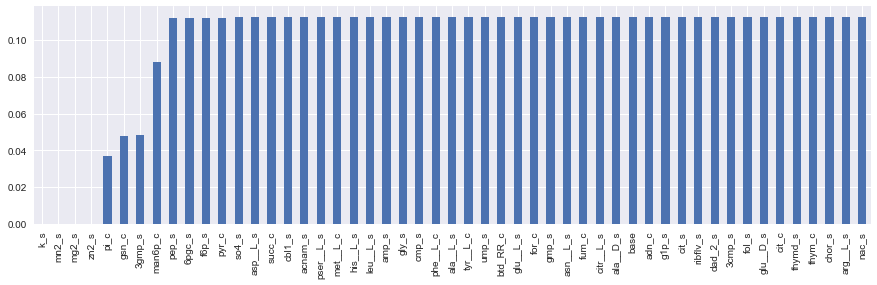

In [51]:
flux_results_df.loc['biomass_dilution_s'].sort_values().plot.bar(figsize=(15,4))

### Open metabolite one by one
Including information about arginine being transported

In [52]:
with open("./sporeme_solution.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [53]:
for r in transport_reactions:
    if r not in all_transporters_to_open and 'SPONT' not in r:
        rxn = sporeme.reactions.get_by_id(r)
        rxn.upper_bound = 0 
        rxn.lower_bound = 0

In [54]:
flux_results_df = pd.read_csv('group_KO_flux_results.csv',index_col=0)
sorted_mets = flux_results_df.loc['biomass_dilution_s'].sort_values(ascending=False).drop('base').index.to_list()

In [56]:
sorted_mets.remove('arg__L_s')
sorted_mets.append('arg__L_s')

In [ ]:
flux_dict = {}
b = 0
for met in tqdm(sorted_mets):
    transport = at_dict[met]
    
    if b == 1:
        flux_dict[met] = {r.id:0. for r in sporeme.reactions}
        continue
    
    for r in transport:
        rxn = sporeme.reactions.get_by_id(r)
        rxn.lower_bound = 0
        rxn.upper_bound = 0
    solve_me_model(sporeme, max_mu = 0.5, min_mu = .05, using_soplex=False, precision = 1e-4,growth_key = 'sigma',
                  verbosity = 0)
    if sporeme.solution:
        flux_dict[met] = sporeme.solution.x_dict
    else:
        flux_dict[met] = {r.id:0. for r in sporeme.reactions}
        b = 1
flux_results_df = pd.DataFrame.from_dict(flux_dict)



  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
flux_results_df.to_csv('group_1by1_KO_flux_results.csv')

In [ ]:
flux_results_df.loc['biomass_dilution_s'].plot.bar(figsize=(15,4))

#### Essential mets

In [ ]:
with open("./sporeme_solution.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [ ]:
flux_results_df = pd.read_csv('group_1by1_KO_flux_results.csv',index_col=0)
sorted_mets = flux_results_df.loc['biomass_dilution_s'].sort_values(ascending=True).index.to_list()
essential_mets = sorted_mets[:18]
print('Essential metabolites: {}'.format(essential_mets))

In [ ]:
essential_transporters = []
for met in essential_mets:
    [essential_transporters.append(i) for i in at_dict[met]]

In [ ]:
print('{} essential open transporters'.format(len(essential_transporters)))

In [ ]:
for r in transport_reactions:
    if r not in essential_transporters and 'SPONT' not in r:
        rxn = sporeme.reactions.get_by_id(r)
        rxn.upper_bound = 0 
        rxn.lower_bound = 0

In [ ]:
solve_me_model(sporeme, max_mu = 0.5, min_mu = .05, using_soplex=False, precision = 1e-6,growth_key = 'sigma')

In [ ]:
from bacillusme.analysis import sensitivity as ss
flux_results_df = ss.transporter_knockout(sporeme,essential_mets, \
                                        NP=10,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma',single_change_function='group_knockout')
flux_results_df.to_csv('essential_metabolite_group_KO.csv')

In [ ]:
flux_results_df.loc['biomass_dilution_s'].plot.bar(figsize=(15,4))

In [ ]:
from bacillusme.analysis import sensitivity as ss
flux_results_df = ss.transporter_knockout(sporeme,essential_transporters, \
                                        NP=10,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma')
flux_results_df.to_csv('essential_transporter_KO.csv')

In [ ]:
flux_results_df.loc['biomass_dilution_s'].plot.bar(figsize=(15,4))

In [ ]:
2

### Network visualization

In [ ]:
import networkx as nx

G=nx.Graph()
G.add_node("a")
G.add_nodes_from(["b","c"])

G.add_edge(1,2)
edge = ("d", "e")
G.add_edge(*edge)
edge = ("a", "b")
G.add_edge(*edge)

print("Nodes of graph: ")
print(G.nodes())
print("Edges of graph: ")
print(G.edges())

In [ ]:
nx.draw(G)
plt.savefig("simple_path.png") # save as png
plt.show() # display